# Load data 

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

from apricot import FacilityLocationSelection
import hdbscan
from sklearn.datasets import make_blobs

# gradient boosting trees
from xgboost import XGBRegressor

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

import math
from collections import defaultdict

from common import load_data, split_data, data_selection

### Import data

In [2]:
data_dir = "../data/"
full_data = load_data(data_dir)

name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = full_data["data"]
inputs_perf = full_data["performance_properties"]
inputs_feat = full_data["features"]
inputs_categ = full_data["features_categorical"]
inputs_num = full_data["features_numerical"]
inputs_feat_cols = full_data["feature_columns"]
inputs_prop = full_data["input_properties"]
inputs_name = full_data["input_names"]
inputs_count = full_data["input_counts"]

random_seed = 100
# system = "gcc"
# train_data, test_data, _ , _ = split_data(
#     data, system, inputs_count, inputs_feat_cols, random_seed
# )

np.random.seed(random_seed)

valid_training_percentages = [(k+1)/10 for k in range(9)] # 0.1 -> 0.9 included

inputs_prop_categ = dict()
inputs_prop_categ["gcc"] = []
inputs_prop_categ["imagemagick"] = ["description"]
inputs_prop_categ["nodejs"] = []
inputs_prop_categ["poppler"] = []
inputs_prop_categ["xz"] = ["type"]
inputs_prop_categ["x264"] = ["category"]
inputs_prop_categ["lingeling"] = []
inputs_prop_categ["sqlite"] = []

data_with_props = dict()
props = dict()
cols = dict()

for ns in name_systems:
    props[ns] = pd.get_dummies(pd.read_csv("../data/"+ns+"/others/properties.csv").set_index("id").drop(["name"], 
                                                                                                    axis = 1), 
                           columns = inputs_prop_categ[ns]).fillna(0)
    df = data[ns, 0]
    cols[ns] = tuple(props[ns].columns)+tuple(df.columns)

for dkey in data.keys():
    ns, input_id = dkey
    df = data[dkey]
    prop_inp = tuple(props[ns].iloc[input_id])
    data_with_props[ns, input_id] = pd.DataFrame([tuple(prop_inp) + tuple(df.iloc[i]) for i in range(df.shape[0])], 
                                                 columns = cols[ns])

# Select indexes of inputs with different selection techniques

In [3]:
input_nb_list = dict()

input_nb_list["poppler"] = [2, 5, 10, 20, 50, 100, 200, 500, 800, 1000, 1300]
input_nb_list["imagemagick"] = [2, 5, 10, 20, 50, 100, 200, 500, 800]
input_nb_list["sqlite"] = [2, 5, 10, 20, 50, 75, 100, 120]
input_nb_list["lingeling"] = [2, 5, 10, 20, 50, 100, 150, 200]
input_nb_list["gcc"] = [2, 5, 10, 20, 25]
input_nb_list["nodejs"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000, 1500]
input_nb_list["xz"] = [2, 5, 10, 25, 30]
input_nb_list["x264"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000]

is_techniques = ["random", "kmeans", "submodular", "hdbscan"]


def get_data_splits(random_seed):
    inputs_indexes = dict()

    # train = dict()
    # val = dict()
    # train_props = dict()
    # val_props = dict()
    

    # for dkey in data.keys():
    #     soft, input_id = dkey
    #     for p in valid_training_percentages:
    #         X_train, X_test = train_test_split(data[soft, input_id], train_size=p, random_state=random_seed)
    #         train[soft, input_id, p] = X_train
    #         val[soft, input_id, p] = X_test
    #         X_train_props, X_test_props = train_test_split(data_with_props[soft, input_id], train_size=p, random_state=random_seed)
    #         train_props[soft, input_id, p] = X_train_props
    #         val_props[soft, input_id, p] = X_test_props

    for ns in name_systems:
        for nb_inp in input_nb_list[ns]:
            # pick nb_inp inputs randomly
            inputs_indexes[ns, "random", nb_inp] = np.random.choice([k for k in range(inputs_count[ns])], nb_inp, replace=False)
            # pick center of clusters with kmeans
            inputs_indexes[ns, "kmeans", nb_inp]  = []
            clusterer = KMeans(n_clusters=nb_inp, random_state=random_seed)
            df = props[ns]
            clusterer.fit(props[ns])
            inputs_indexes[ns, "kmeans", nb_inp] = clusterer.transform(df).argmin(axis=0)
            # cluster_labels = clusterer.predict(df)
            #dist to center of the cluster
            # df["dist"] = clusterer.inertia_
            # df["label"] = cluster_labels
            # labs = pd.Series(cluster_labels).unique()
            # nb_inp_per_cluster = int(nb_inp/len(labs))
            # nb_cluster_with_one_addi_input = nb_inp%len(labs)
            # for i in range(len(labs)):
            #     lab = labs[i]
            #     df2 = df.query("label=='"+str(lab)+"'")
            #     df2 = df2.sort_values(by="dist", ascending = True)
            #     if i>=nb_cluster_with_one_addi_input:
            #         inputs_indexes[ns, "kmeans", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster])
            #     else:
            #         inputs_indexes[ns, "kmeans", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster+1])
            # submodular
            X = props[ns]
            fls = FacilityLocationSelection(
                nb_inp,
                metric="euclidean",
                optimizer="lazy",
                random_state=random_seed,
            ).fit(X)
            result = X.iloc[fls.ranking]
            inputs_indexes[ns, "submodular", nb_inp] = [k for k in result.index]
            # hdbscan
            inputs_indexes[ns, "hdbscan", nb_inp]  = []
            clusterer = hdbscan.HDBSCAN()
            df = props[ns]
            cluster_labels = clusterer.fit_predict(props[ns])
            df["probs"] = clusterer.probabilities_
            df["label"] = cluster_labels
            labs = pd.Series(cluster_labels).unique()
            nb_inp_per_cluster = int(nb_inp/len(labs))
            nb_cluster_with_one_addi_input = nb_inp%len(labs)
            for i in range(len(labs)):
                lab = labs[i]
                df2 = df[df.label==lab]
                df2 = df2.sort_values(by="probs", ascending = False)
                if i>=nb_cluster_with_one_addi_input:
                    inputs_indexes[ns, "hdbscan", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster])
                else:
                    inputs_indexes[ns, "hdbscan", nb_inp].extend([k for k in df2.index][0:nb_inp_per_cluster+1])

    return inputs_indexes

#### The indexes of inputs selected for the software system x264, with the hdbscan input selection technique and 10 inputs as budget

In [4]:
# inputs_indexes["x264", "hdbscan", 10]

### Compare different (offline) input selection strategies

In [5]:
res_rq2_long = defaultdict(list)

for iter in range(20):
    iter_seed = random_seed+iter
    np.random.seed(iter_seed)
    inputs_indexes = get_data_splits(iter_seed)

    for ns in name_systems:    
        print(f"{ns} @ iter {iter}")
        list_df = []
        for i in range(1, inputs_count[ns]):
            df = data_with_props[ns, i]
            df["input_id"] = i
            #for col in df.columns:
            #    df[col] = (df[col]-np.mean(df[col]))/(np.std(df[col])+1e-4)
            for perf in inputs_perf[ns]:
                df[perf] = (df[perf]-np.mean(df[perf]))/np.std(df[perf])
            list_df.append(df)
        final = pd.concat(list_df).fillna(0)
    
        for perf in inputs_perf[ns]:
            #perf = "size"
            
            other_perf = [perf for perf in inputs_perf[ns]]
            other_perf.remove(perf)
            other_perf.append("input_id")

            for nb_inp in input_nb_list[ns]:
                #nb_inp = 10
                
                for ist in is_techniques:
                    #ist = "random"
                    
                    try:                      
                        inp_ind = inputs_indexes[ns, ist, nb_inp]
                        s = "["
                        for ii in inp_ind:
                            s+=str(ii)+","
                        s=s[:-1]+"]"

                        df_train = final.query("input_id in"+s).drop(other_perf, axis=1)
                        X_train = df_train.drop([perf], axis = 1)
                        y_train = df_train[perf]

                        df_test = final.query("input_id not in"+s).drop(other_perf, axis=1)
                        X_test = df_test.drop([perf], axis = 1)
                        y_test = df_test[perf]

                        dt = XGBRegressor(random_state=iter_seed)
                        dt.fit(X_train, y_train)
                        y_pred = dt.predict(X_test)
                        
                        res_rq2_long[ns, perf, nb_inp, ist].append(mean_absolute_error(y_pred, y_test))
                    
                    except Exception as e:
                        print(ns, perf, nb_inp, ist, e)

res_rq2 = dict()
for k, v in res_rq2_long.items():
    res_rq2[k] = np.mean(v)

nodejs @ iter 0
poppler @ iter 1931
xz @ iter 1478
xz size 2 random Invalid shape: (60, 2) for label
xz size 2 kmeans Invalid shape: (60, 2) for label
xz size 2 submodular Invalid shape: (30, 2) for label
xz size 2 hdbscan Invalid shape: (30, 2) for label
xz size 5 random Invalid shape: (150, 2) for label
xz size 5 kmeans Invalid shape: (150, 2) for label
xz size 5 submodular Invalid shape: (120, 2) for label
xz size 5 hdbscan Invalid shape: (120, 2) for label
xz size 10 random Invalid shape: (300, 2) for label
xz size 10 kmeans Invalid shape: (270, 2) for label
xz size 10 submodular Invalid shape: (270, 2) for label
xz size 10 hdbscan Invalid shape: (270, 2) for label
xz size 25 random Invalid shape: (750, 2) for label
xz size 25 kmeans Invalid shape: (720, 2) for label
xz size 25 submodular Invalid shape: (720, 2) for label
xz size 25 hdbscan Invalid shape: (600, 2) for label
xz size 30 random Invalid shape: (870, 2) for label
xz size 30 kmeans Invalid shape: (870, 2) for label
xz si

In [ ]:
res_rq2

{('nodejs', 'ops', 2, 'random'): 0.572432040209865,
 ('nodejs', 'ops', 2, 'kmeans'): 1.2023370686811456,
 ('nodejs', 'ops', 2, 'submodular'): 0.5593618886813037,
 ('nodejs', 'ops', 2, 'hdbscan'): 1.2023370686811456,
 ('nodejs', 'ops', 5, 'random'): 0.6836912709628317,
 ('nodejs', 'ops', 5, 'kmeans'): 0.934437657375111,
 ('nodejs', 'ops', 5, 'submodular'): 0.5604367209316871,
 ('nodejs', 'ops', 5, 'hdbscan'): 0.9649680564917527,
 ('nodejs', 'ops', 10, 'random'): 0.6519686404845909,
 ('nodejs', 'ops', 10, 'kmeans'): 0.7854457468583467,
 ('nodejs', 'ops', 10, 'submodular'): 0.5620700475657241,
 ('nodejs', 'ops', 10, 'hdbscan'): 0.8861985790981024,
 ('nodejs', 'ops', 25, 'random'): 0.6516454895539006,
 ('nodejs', 'ops', 25, 'kmeans'): 0.736502383338179,
 ('nodejs', 'ops', 25, 'submodular'): 0.7973531799342705,
 ('nodejs', 'ops', 25, 'hdbscan'): 0.6111700255537772,
 ('nodejs', 'ops', 50, 'random'): 0.5826005865471666,
 ('nodejs', 'ops', 50, 'kmeans'): 0.7992016242570423,
 ('nodejs', 'ops', 

In [ ]:
rq2_lines = []

for mae in res_rq2.keys():
    ns, perf, nb_inp, ist = mae
    rq2_lines.append((ns, perf, nb_inp, ist, res_rq2[mae]))
    
final_rq2 = pd.DataFrame(rq2_lines, columns = ["soft", "perf", "nb_inputs", "is_tech", "mae"])
final_rq2.to_csv("../results/RQ2_data_helge.csv")

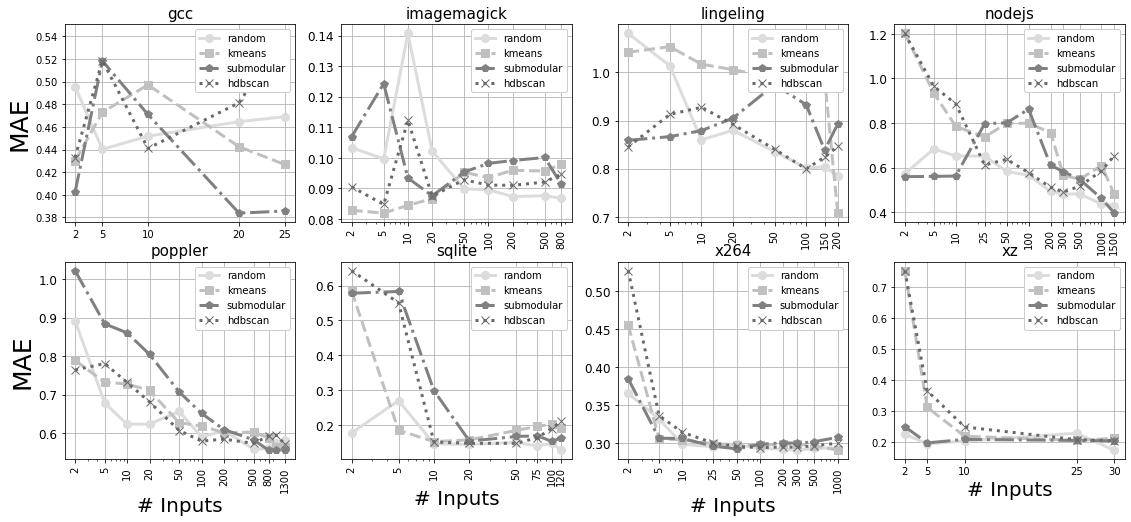

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(19, 8)

linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
colors = ["gainsboro", "silver", "gray", "dimgray"]
markers = ['o', 's', 'p', 'x']

for i in range(len(name_systems)):
    ns = sorted(name_systems)[i]
    # Draw a nested boxplot to show bills by day and time
    for j in range(len(is_techniques)):
        ist = is_techniques[j]
        tab = [np.mean([res_rq2[k] for k in res_rq2.keys() if k[2]==nb_inp and k[0]==ns and k[3] == ist]) for nb_inp in input_nb_list[ns]]
        axs[int(i/4), i%4].plot(input_nb_list[ns], tab, linewidth=3, linestyle = linestyles[j], c= colors[j],
                                marker = markers[j], markersize = 8, label=ist, color=colors[j])
    axs[int(i/4), i%4].set_title(ns, fontsize =15)
    axs[int(i/4), i%4].grid(axis="both")
    #axs[i%4, int(i/4)].set_ylim(0, np.percentile(final_rq2.query("soft=='"+soft+"'")["val"], 95))
    axs[int(i/4), i%4].legend(fontsize=10, loc = 'upper right', framealpha=1)
    if i >=4:
        axs[int(i/4), i%4].set_xlabel("# Inputs", size = 20)
    else:
        axs[int(i/4), i%4].set_xlabel("")
    if i%4==0:
        axs[int(i/4), i%4].set_ylabel("MAE", size = 25)
    if ns in ["xz", 'gcc']:
        #axs[int(i/4), i%4].set_xscale('log')
        axs[int(i/4), i%4].get_xaxis().get_minor_formatter().labelOnlyBase = False
        axs[int(i/4), i%4].set_xticks(input_nb_list[ns], minor= False)
    elif ns == "poppler":
        axs[int(i/4), i%4].set_xscale('log')
        axs[int(i/4), i%4].set_xticks([2, 5, 10, 20, 50, 100, 200, 500, 800, 1300], minor= False)
        axs[int(i/4), i%4].tick_params(axis='x', labelrotation= 90)
        axs[int(i/4), i%4].tick_params(axis='y', which='major', labelsize=12)
        axs[int(i/4), i%4].get_xaxis().set_major_formatter(ScalarFormatter())
    else:
        axs[int(i/4), i%4].set_xscale('log')
        axs[int(i/4), i%4].set_xticks(input_nb_list[ns], minor= False)
        axs[int(i/4), i%4].tick_params(axis='x', labelrotation= 90)
        axs[int(i/4), i%4].tick_params(axis='y', which='major', labelsize=12)
        axs[int(i/4), i%4].get_xaxis().set_major_formatter(ScalarFormatter())
        
# Arrow
# plt.arrow(x = 4.5, y = 2, dx= 0, dy = -0.3, head_width = 0.15, head_length = .1, color="orange")
# plt.text(s = "Better", x = 4, y = 1.95, size = 20, color = 'orange')

#plt.xticks(size = 20)
#plt.yticks(size = 20)
plt.savefig("../results/RQ2_eval_all.png", dpi = 300)
plt.show()